In [2]:
import time
from dataclasses import dataclass
from dataclasses import field
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
DAY_SECONDS = 60 * 60 * 24


def today() -> pd.Timestamp:
    """
    pd.Timestamp today midnight
    """
    seconds = time.time() - time.timezone
    seconds_round_day = seconds - (seconds % DAY_SECONDS)
    return pd.Timestamp.fromtimestamp(seconds_round_day + time.timezone)

Pick some bonds to use in the current optimization

In [4]:
BOND_UNIVERSE: tuple[str] = (
    "RU000A0GN9A7",
    "RU000A0JV4N8",
    "RU000A0JWDN6",
    "RU000A0JV4Q1",
    "RU000A0JVA10",
    "RU000A0JW0S4",
    "RU000A0JUMH3",
)

In [9]:
from functools import cached_property


class BondDataProvider:
    """Data provider for bonds and"""

    def __init__(self):
        """Read all pre-downloaded data."""
        df_price = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_price.csv", parse_dates=["date"])
        df_price["date"] = df_price["date"].dt.date
        df_price = df_price.set_index(["date", "isin"])
        self._price = df_price.sort_index(level="date")

        self._dur = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_duration.csv", parse_dates=["date"])
        self._dur["date"] = self._dur["date"].dt.date
        self._dur = self._dur.set_index(["date", "isin"]).sort_index(level="date")

        self._static = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_static.csv")
        self._rating = pd.read_csv(
            "/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rating.csv", parse_dates=["update_date"]
        )
        self._rating["update_date"] = self._rating["update_date"].dt.date

        self._volume = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_volume.csv")
        self._rgbitr = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rgbitr.csv", parse_dates=["date"])

        self._yield = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_yield.csv", parse_dates=["date"])
        self._yield["date"] = pd.to_datetime(self._yield["date"].dt.date)
        self._yield = self._yield.sort_values("date")

    @property
    def price(self):
        """
        df with bond's historical prices
        columns: 'isin','date','spread','ask','bid','ai','last','mid'
        """
        return self._price

    @property
    def duration(self):
        """
        df with bond's precomputed duration data
        columns: 'id','date','isin','emission_id','emission_emitent_id','trading_ground_id','avar_price',
        'convexity','convexity_offer','dur','dur_to','dur_mod','dur_mod_to'
        """
        return self._dur

    @property
    def static(self):
        """Static bond info including coupon data."""
        return self._static

    @property
    def rating(self):
        """Bond ratings data."""
        return self._rating

    @property
    def volume(self):
        """Traded volume data.
        columns: 'volume' -- traded volume ,'volume_lots' -- number of traded lots
        """
        return self._volume

    @property
    def yield_(self):
        """Estimated bond yields."""
        return self._yield

    @cached_property
    def rgbitr(self):
        """RGBITR benchmark."""
        return self._rgbitr[self._rgbitr["secid"] == "RGBITR"]

    @cached_property
    def rucbitr(self):
        """RUCBITR benchmark.

        Note: halts after 05/31/2023
        """
        return self._rgbitr[self._rgbitr["secid"] == "RUCBITR"]


bond_data = BondDataProvider()

In [10]:
@dataclass
class BondPortfolio:
    """portfolio history and basic statistics."""

    bond_universe: tuple[str] = field(default=tuple)
    cash: float = 1

    def __post_init__(self):
        self.universe_size: int = len(self.bond_universe)

        # current portfolio portions of bonds from the universe
        self._weights: np.array = np.zeros(self.universe_size)

        # current quantities of bonds from the universe
        self._qty: np.array = np.zeros(self.universe_size)

        self._history_weights: dict[pd.Timestamp, np.array] = {}
        self._history_qty: dict[pd.Timestamp, np.array] = {}

        # current date
        self._date: pd.Timestamp = today()

    def update_portfolio(
        self, weights: np.array, qty: np.array, cash: float, date: pd.Timestamp
    ):
        """Should be called when bonds quantity is changed"""
        self._date = date
        self.cash = cash

        self._weights = weights
        self._history_weights[date] = weights

        self._qty = qty
        self._history_qty[date] = qty

    @property
    def weights(self):
        """Weights for the current_date."""
        return self._weights

    def wealth(self, prices: np.array):
        """Total value af assets and money on account."""
        return self.cash + self._qty @ prices

In [14]:
# create portfolio for a simple strategy
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

## Random Weights Strategy

In [17]:
%%time
start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
day_ = pd.Timedelta(days=1)

dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)
    a = (np.random.uniform(-1, 1, port.universe_size) + 1) / 2

    price_today = bond_data.price.loc[
        pd.IndexSlice[slice(date, date), port.bond_universe], :
    ]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    new_weights = a / a.sum(axis=0, keepdims=1)

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today
    print(new_weights - port.weights)
    cash = wealth - qty @ price_today
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
[0.01739662 0.2395482  0.23850228 0.24559372 0.05578985 0.11531217
 0.08785716]
2023-08-02
wealth = 0.9989145536155618
[ 0.17481278 -0.18041995 -0.15611827 -0.20217405  0.08422835  0.12623551
  0.15343562]
2023-08-03
wealth = 0.9963944307034601
[-0.122566    0.06471845  0.16555129 -0.01041865 -0.00483793  0.02722944
 -0.11967661]
2023-08-04
wealth = 0.9943429095481829
[-0.04593916 -0.01957342 -0.02435869  0.27645103  0.12559551 -0.22169637
 -0.0904789 ]
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9917362149251694
[ 0.10227676  0.04143741  0.00552189 -0.12025964 -0.20652012  0.07898819
  0.09855551]
2023-08-08
wealth = 0.9946390074042046
[-0.10614323  0.00518542 -0.16236676  0.02881543  0.26829814 -0.06528721
  0.03149822]
2023-08-09
wealth = 0.9947817825435681
[ 0.18857274 -0.11077648  0.13208586 -0.00384779 -0.16147421 -0.05102092
  0.0064608 ]
2023-08-10
wealth = 0.9961399085420625
[-0.09875127  0.19218804 -0.19856261 -0.17899978  0.07608944  0.31476458
 -0.10

### Random Weights Strategy Results

In [18]:
wealth

0.9689527624919602

## Sharpe Ratio Strategy

basic statistic to optimize in a portfolio.
it compares the return of an investment with its risk, so it seeks to pick find an offset between high yield and low risk

In [19]:
# df with "dur_mod", "yield", "shape" field for each day and each bond
sharpe_data = (
    bond_data.duration.groupby(["date", "isin"])
    .dur_mod.mean()
    .to_frame()
    .loc[(slice(None), BOND_UNIVERSE), ["dur_mod"]]
    .fillna(float("inf"))
    .join(
        bond_data.yield_.set_index(["date", "isin"]).loc[
            (slice(None), BOND_UNIVERSE), ["yield"]
        ],
    )
)

sharpe_data["sharpe"] = sharpe_data["yield"] / sharpe_data["dur_mod"]
sharpe_data = sharpe_data.sort_index()

In [20]:
sharpe_data_sorted = sharpe_data.loc[date].sort_values(
    "sharpe", ascending=False
)
sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
sharpe_data_sorted["weight"] = (
    sharpe_data_sorted["sharpe_squared"]
    / sharpe_data_sorted["sharpe_squared"].sum()
)
sharpe_data_sorted
# select max sharp
# weights = (
#     sharpe_data_sorted.loc[(slice(None), universe), :]

dur_mod     yield    sharpe  sharpe_squared    weight
isin                                                                
RU000A0JUMH3  0.588109  0.115846  0.196981        0.038802  0.651056
RU000A0JVA10  1.177732  0.132693  0.112669        0.012694  0.212997
RU000A0JW0S4  1.855754  0.127511  0.068711        0.004721  0.079218
RU000A0JWDN6  2.274082  0.118546  0.052129        0.002717  0.045596
RU000A0GN9A7  6.657464  0.115169  0.017299        0.000299  0.005021
RU000A0JV4N8  5.636553  0.081891  0.014529        0.000211  0.003542
RU000A0JV4Q1  6.702876  0.082937  0.012373        0.000153  0.002569

In [21]:
sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )

dur_mod     yield    sharpe
date       isin                                      
2023-09-20 RU000A0JUMH3  0.588109  0.115846  0.196981
           RU000A0JVA10  1.177732  0.132693  0.112669
           RU000A0JW0S4  1.855754  0.127511  0.068711
           RU000A0JWDN6  2.274082  0.118546  0.052129
           RU000A0GN9A7  6.657464  0.115169  0.017299
           RU000A0JV4N8  5.636553  0.081891  0.014529
           RU000A0JV4Q1  6.702876  0.082937  0.012373

In [22]:
port = BondPortfolio(
    cash=1,
    bond_universe=BOND_UNIVERSE,
)

In [23]:
def get_weights(date: datetime.date, universe: tuple[str]):
    """Get target weights based on sharpe ratio."""
    sharpe_data_sorted = sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )
    sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
    sharpe_data_sorted["weight"] = (
        sharpe_data_sorted["sharpe_squared"]
        / sharpe_data_sorted["sharpe_squared"].sum()
    )

    # select max sharp
    weights = (
        sharpe_data_sorted.loc[(slice(None), universe), :]
        .reset_index()["weight"]
        .fillna(0)
        .values
    )
    assert len(weights) == len(universe), f"{len(weights)},  {len(universe)}"
    return weights

In [18]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    new_weights = get_weights(date, BOND_UNIVERSE)  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = -2.220446049250313e-16
2023-08-02
wealth = 0.999877605997308
cash = 0.0
2023-08-03
wealth = 0.997852737113143
cash = 2.220446049250313e-16
2023-08-04
wealth = 0.9979638505969904
cash = 1.1102230246251565e-16
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9964516162626471
cash = 1.1102230246251565e-16
2023-08-08
wealth = 0.9968897272080548
cash = 4.440892098500626e-16
2023-08-09
wealth = 0.9952035884008431
cash = -1.1102230246251565e-16
2023-08-10
wealth = 0.9989990726492806
cash = 0.0
2023-08-11
wealth = 0.9959058195303009
cash = 1.1102230246251565e-16
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9964227757856775
cash = 0.0
2023-08-15
wealth = 0.9859243737486095
cash = 0.0
2023-08-16
wealth = 0.9928902742058036
cash = 0.0
2023-08-17
wealth = 0.9896478701483994
cash = -1.1102230246251565e-16
2023-08-18
wealth = 0.9898619585040244
cash = -1.1102230246251565e-16
2023-08-19
2023-08-20
2023-08-21
wealth = 0.9945369243255121
cash = 1.1102230246251565e-16
2023-08-22

### Sharpe Ratio Strategy Results

In [24]:
wealth

0.9689527624919602

## Quadratic optimization

In [33]:
%%time

from baseline.quadratic import get_optimal_weights

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )
    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()

    today_info = today_info.join(rating_reduced)
    today_info["num_rating"] = today_info["num_rating"].fillna(0)
    #
    # make predictions
    #
    new_weights = get_optimal_weights(
        bond_data=today_info,
        upper_bound=0.5,
        value_date=date,
        maturity_limit=10,
    )  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

ModuleNotFoundError: No module named 'baseline'

In [21]:
wealth

0.9589643043212827

In [30]:
from scipy.optimize import linprog

# Basic analytics

In [31]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
      continue

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )
    today_info['yield_dur'] = today_info['yield'] / today_info['dur_mod']
    obj = today_info['yield_dur'][(date, slice(None))].sort_index().array

    lhs_ineq = [
          [1] * len(obj),
          [-1] * len(obj)
    ]

    rhs_ineq = [
        1,
        -1
    ]

    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, method="revised simplex")
    new_weights = opt['x']

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.016397801623113
cash = 0.0
2023-08-02


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0141639603008645
cash = 0.0
2023-08-03


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0141639603008645
cash = 0.0
2023-08-04


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0143670367847053
cash = 0.0
2023-08-05
2023-08-06
2023-08-07


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0153824192039091
cash = 0.0
2023-08-08


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0153824192039091
cash = 0.0
2023-08-09


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0147731897523868
cash = 0.0
2023-08-10


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0147731897523868
cash = 0.0
2023-08-11


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0153824192039091
cash = 0.0
2023-08-12
2023-08-13
2023-08-14


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.014570113268546
cash = 0.0
2023-08-15


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0136562690912625
cash = 0.0
2023-08-16


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.013554730849342
cash = 0.0
2023-08-17


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0137578073331828
cash = 0.0
2023-08-18


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0151793427200684
cash = 0.0
2023-08-19
2023-08-20
2023-08-21


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0131485778816605
cash = 0.0
2023-08-22


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.014062422058944
cash = 0.0
2023-08-23


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0141639603008645
cash = 0.0
2023-08-24


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.014062422058944
cash = 0.0
2023-08-25


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0141639603008645
cash = 0.0
2023-08-26
2023-08-27
2023-08-28


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0294962348308434
cash = 0.0
2023-08-29


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0233024020736996
cash = 0.0
2023-08-30


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.025372553625354
cash = 0.0
2023-08-31


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0267068693174155
cash = 0.0
2023-09-01


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.025254819887819
cash = 0.0
2023-09-02
2023-09-03
2023-09-04


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.023400513521645
cash = 0.0
2023-09-05


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0241461605260325
cash = 0.0
2023-09-06


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0253529313357648
cash = 0.0
2023-09-07


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0227824113995871
cash = 0.0
2023-09-08


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0232042906257537
cash = 0.0
2023-09-09
2023-09-10
2023-09-11


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0220269532504052
cash = 0.0
2023-09-12


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0240088044989082
cash = 0.0
2023-09-13


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0236850367206873
cash = 0.0
2023-09-14


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0213401731147849
cash = 0.0
2023-09-15


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.020359058635328
cash = 0.0
2023-09-16
2023-09-17
2023-09-18


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0196134116309408
cash = 0.0
2023-09-19


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


wealth = 1.0190443652328554
cash = 0.0
2023-09-20
wealth = 1.0182006067805225
cash = 0.0
CPU times: user 7.92 s, sys: 3.01 s, total: 10.9 s
Wall time: 11.2 s


<timed exec>:50: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.


In [29]:
wealth

1.0017737200479289

In [22]:
def get_portfolio_value_history(portfolio: BondPortfolio):
    """
    df with 'qty', 'spread', 'ask', 'bid', 'ai', 'last', 'mid' columns for each bond and trading day of the `portfolio`
    """
    portfolio_df = pd.DataFrame.from_dict(
        portfolio._history_qty, orient="index", columns=portfolio.bond_universe
    )
    portfolio_df.index.name = "date"

    # wide df -> long df
    portfolio_df = pd.melt(
        portfolio_df.reset_index(),
        "date",
        value_vars=portfolio.bond_universe,
        var_name="isin",
        value_name="qty",
    ).set_index(["date", "isin"])

    price_df = bond_data.price.reset_index()
    price_df = price_df.set_index(["date", "isin"])

    portfolio_history = pd.merge(
        portfolio_df,
        price_df,
        how="left",
        left_index=True,
        right_index=True,
    )

    return portfolio_history

#### portfolio PNL

In [23]:
portfolio_summary = get_portfolio_value_history(port)
portfolio_summary["value"] = portfolio_summary["qty"] * portfolio_summary["mid"]
portfolio_summary_grouped = portfolio_summary.groupby("date")

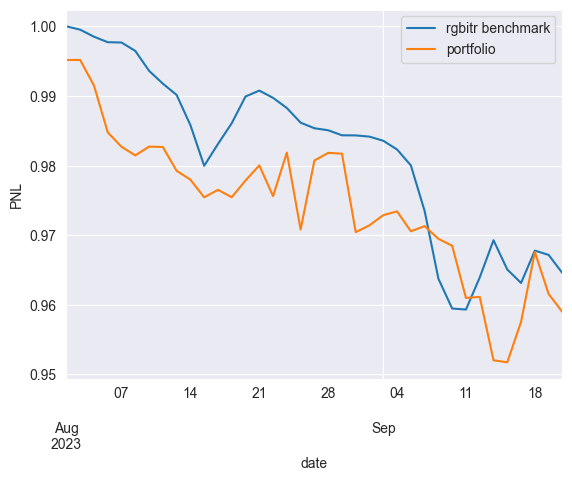

In [24]:
# benchmark rgbitr
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]
pnl_benchmark = np.cumprod(rgbitr_slice.close.pct_change().fillna(0) + 1)
pnl_benchmark.index = pd.DatetimeIndex(pnl_benchmark.index)
pnl_benchmark.plot(label="rgbitr benchmark")

# portfolio
pnl_portfolio = portfolio_summary_grouped.value.sum()
pnl_portfolio.index = pd.DatetimeIndex(pnl_portfolio.index)
pnl_portfolio.plot(label="portfolio")

plt.legend()
plt.ylabel("PNL");

### mean and median return

In [25]:
returns = portfolio_summary_grouped.value.sum().pct_change()
f"Mean return = {returns.mean():.3f}, Median return = {returns.median():.3f}"

'Mean return = -0.001, Median return = -0.001'

## Sharpe Ratio

In [26]:
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]

returns_benchmark = rgbitr_slice.close.pct_change().iloc[1:]
returns_port = portfolio_summary_grouped.value.sum().pct_change().iloc[1:]

In [27]:
def get_sharp_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/s/sharperatio.asp
    """
    delta = returns.product() - returns_market.product()
    return delta / (returns - returns_market).std()


get_sharp_ratio(returns=returns_benchmark, returns_market=returns_port)

1.53600326463795e-98

### Information Ratio

In [28]:
def get_information_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/i/informationratio.asp
    """
    difference_benchmark_portfolio = returns - returns_market
    tracking_error = difference_benchmark_portfolio.std()
    information_ratio = (returns.mean() - returns_market.mean()) / tracking_error
    return information_ratio

In [29]:
information_ratio = get_information_ratio(
    returns=returns_benchmark, returns_market=returns_port
)
information_ratio

0.0035176129885404134

## Returns

/var/folders/9w/txlxlj150xxgp7zy568gnwjn7lbpgp/T/ipykernel_98213/921857431.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
/var/folders/9w/txlxlj150xxgp7zy568gnwjn7lbpgp/T/ipykernel_98213/921857431.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

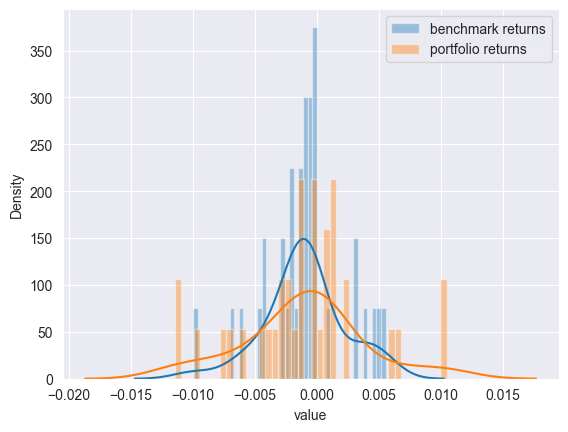

In [30]:
plt.figure()
sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
sns.distplot(returns_port, bins=42, label="portfolio returns")
plt.legend();

# Returns difference

/var/folders/9w/txlxlj150xxgp7zy568gnwjn7lbpgp/T/ipykernel_98213/3621973020.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(returns_diff, bins=42, label="portfolio returns");


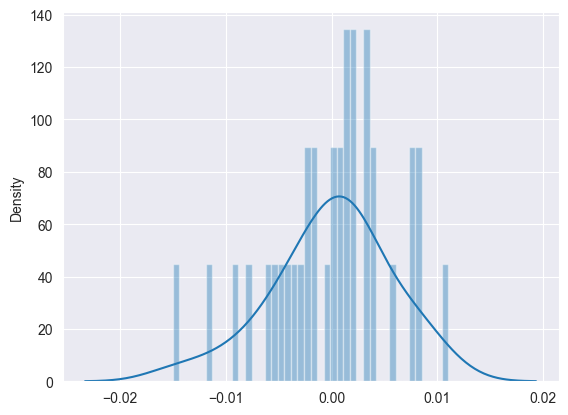

In [31]:
returns_diff = returns_port - returns_benchmark
sns.distplot(returns_diff, bins=42, label="portfolio returns");

In [32]:
from scipy import stats

stats.ttest_1samp(returns_diff, popmean=0)

TtestResult(statistic=-0.021105677931242302, pvalue=0.9832812222909604, df=35)

# Benchmark Timing

One financially based refinement to the regression model is a benchmark timing component. The expanded model is

$$r_{P}(t) = \alpha_{P}+\beta_{P} * r_{B}(t) + \gamma_{P} * max(0, r_{B}(t)) + \epsilon_{P}(t)$$

We include the variable γP to determine whether the manager has any benchmark timing skill. The model includes a "down-market" beta, βP, and an "up-market" beta, βP + γP. If γP is significantly positive, then we say that there is evidence of timing skill; benchmark exposure is significantly different in up and down cases.


In [33]:
import statsmodels.api as sm
import numpy as np

timing_df = returns_benchmark.to_frame().rename(columns={'close':'beta'})
timing_df['gamma'] = timing_df['beta']
timing_df.loc[timing_df['beta'] < 0, 'gamma'] = 0

X = sm.add_constant(timing_df)
benchmark_timing_model = sm.OLS(returns_port,X)
results = benchmark_timing_model.fit()
results.params

const   -0.001457
beta    -0.073636
gamma    0.504815
dtype: float64

## Value at Risk

In [34]:
alpha = 0.05
returns_benchmark.quantile(alpha)

-0.006116591003621885

## Skewness of Returns

In [35]:
alpha = 0.05
returns_benchmark.skew()

-0.20963976217357644